# Explaining a vision transformer for image classification
This notebook illustrates how to explain a Vision Transformer (ViT) image classifier using Shapley Interactions. We will use the `ImageClassifierLocalXAI` benchmark game to explain the model. The game will transform the image into patches and explain the model's predictions. We will use the `ExactComputer` to compute the exact Shapley values for the game. The notebook will show how to load the image, create the game, precompute the values, and explain the model. The notebook will also show how to plot the network of the explanation.

### Load the Image and Benchmark Game

In [1]:
# import the correct game
from PIL import Image

import shapiq
from shapiq.games.benchmark import ImageClassifierLocalXAI

print(f"shapiq version: {shapiq.__version__}")

shapiq version: 1.3.1


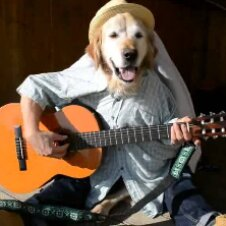

In [2]:
# get an image
image_path = "../images/original_image.jpg"
image = Image.open(image_path)
image

In [3]:
# create the game
game = ImageClassifierLocalXAI(
    model_name="vit_9_patches",
    x_explain_path=image_path,
    verbose=True,
)
print("Number of players:", game.n_players)  # the image is transformed into 9 patches

/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Number of players: 9


In [4]:
# let's precompute the game to make it faster later
save_path = f"../data/pre_computed_image_{game.n_players}.npz"
game.precompute()
game.save_values(save_path)

Evaluating game:   0%|          | 0/512 [00:00<?, ? coalition/s]

### Explain the Image Classifier with 9 patches

In [5]:
# load the precomputed values
from shapiq.games import Game

game_loaded = Game(path_to_values=save_path, normalize=True)

In [6]:
# get the exact SII values explanation
from shapiq import ExactComputer

exact = ExactComputer(n_players=game_loaded.n_players, game=game_loaded)
sii = exact(index="k-SII", order=2)
sii

InteractionValues(
    index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=9, baseline_value=0.0
)

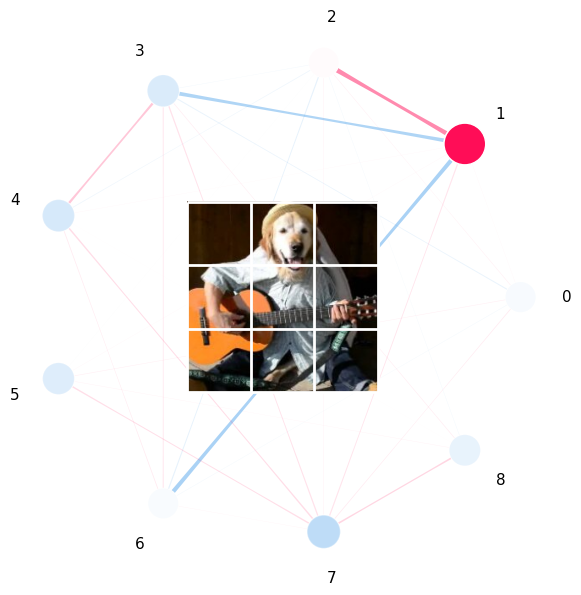

In [7]:
center_image = Image.open(image_path)
sii.plot_network(center_image=center_image)

### Explain the Image Classifier with 16 patches

In [8]:
# load the 16 player values and explain
save_path = f"../data/pre_computed_image_{game.n_players}.npz"
try:
    game_loaded = Game(path_to_values=save_path, normalize=True)
except FileNotFoundError:
    print("File not found, creating the game")
    game = ImageClassifierLocalXAI(
        model_name="vit_16_patches",
        x_explain_path=image_path,
        verbose=True,
    )
    print("Number of players:", game.n_players)  # the image is transformed into 16 patches
    game.precompute()
    game.save_values(save_path)
    game_loaded = Game(path_to_values=save_path, normalize=True)
exact = ExactComputer(n_players=game_loaded.n_players, game=game_loaded)
sii = exact(index="k-SII", order=2)
sii

InteractionValues(
    index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=9, baseline_value=0.0
)

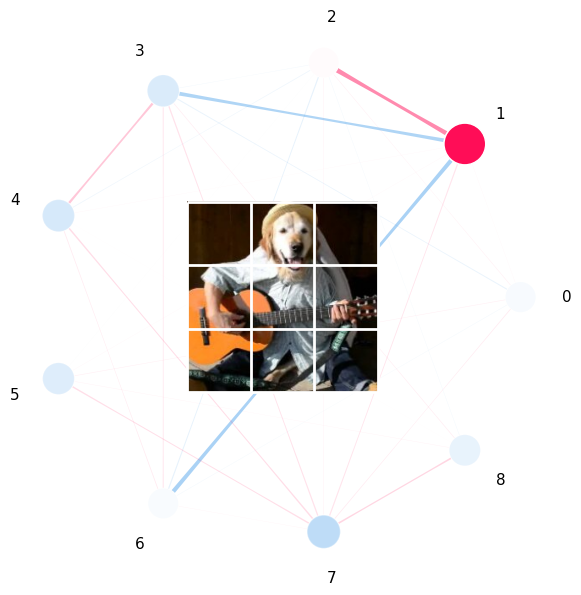

In [9]:
# plot the network
center_image = Image.open(image_path)
sii.plot_network(center_image=center_image)

### Explain the Image Classifier with 36 patches

In [10]:
# load the 36 player values and explain
big_game = ImageClassifierLocalXAI(
    model_name="vit_36_patches",
    x_explain_path=image_path,
)
print("Number of players:", big_game.n_players)  # the image is transformed into 36 patches
print("Takes ~6min on an M1 Macbook Pro")
# For 36 patches, consider using order 1 for simpler explanations
scalable_approximator = shapiq.SPEX(
    n=big_game.n_players, max_order=2, index="SII"
)  # Here we use max order=2,
large_sii = scalable_approximator.approximate(budget=9000, game=big_game)
print(large_sii)

Number of players: 36
Takes ~6min on an M1 Macbook Pro


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=True, estimation_budget=5376,
    n_players=36, baseline_value=0,
    Top 10 interactions:
        (np.int64(9),): 0.10230436464577221
        (np.int64(3), np.int64(9)): 0.08295086375689628
        (np.int64(8), np.int64(9)): 0.056224368293558036
        (np.int64(3),): 0.05425831392901741
        (np.int64(9), np.int64(15)): 0.05191937202754163
        (np.int64(15),): 0.040054132325763846
        (np.int64(8),): 0.0393064743377257
        (np.int64(9), np.int64(10)): 0.03870948158179845
        (np.int64(9), np.int64(27)): 0.027487973503960053
        (np.int64(9), np.int64(20)): -0.03141003847434793
)


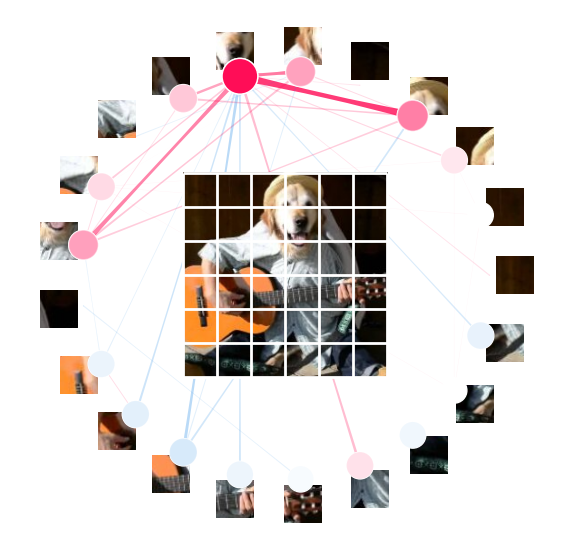

In [11]:
# get the image patches
import math

n_players_per_row = math.isqrt(large_sii.n_players)
width, height = image.size
patch_width = width // n_players_per_row
patch_height = height // n_players_per_row
patches = []
for row in range(n_players_per_row):
    for col in range(n_players_per_row):
        left = col * patch_width
        upper = row * patch_height
        right = left + patch_width
        lower = upper + patch_height
        patch = image.crop((left, upper, right, lower))
        patches.append(patch)

# draw the plot
large_sii.plot_network(
    center_image=center_image,
    center_image_size=0.5,
    feature_image_patches=patches,
    feature_image_patches_size=0.08,
)